In [4]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm


from scipy.optimize import curve_fit
import json
import arviz as az

# import custom class
from RandomLoop import StateSpace, create_cmap
from IPython.display import HTML


MEDIA_PATH = r'C:\Users\lollo\Documents\Università\Thesis\Media/'

plt.style.use("default")
#plt.style.use("dark_background")
#plt.style.use("seaborn-v0_8-pastel")
#plt.style.use("fast")

# Mixing time 

$$
T_{mix} \simeq 7\beta n^2
$$

In [ ]:
%matplotlib inline

def check_equilibrium(eps = 1e-3):
    data = np.mean(m.data['mean_links'], axis=1)
    v1 = np.mean(data[-100:-50])
    v2 = np.mean(data[-50:])
    delta = abs((v2-v1)/v2)
    
    if delta <= eps:
        #print(f'Reached equilibrium at step {m.accepted + m.rejected}')
        m.stop = True 
    return delta

STEPS = 5_000_000
SAMPLE_RATE = 1_000
TRIALS = 10
# define an array of betas
betas = np.linspace(1, 50, 12)

T_mix = []

for beta in tqdm(betas):
    tot = 0
    for _ in range(TRIALS):
        m = StateSpace(num_colors=3, grid_size=32, beta=beta, init=0, bc=0, algo='metropolis')  
        observables = [m.mean_links, check_equilibrium]
        m.step(num_steps=STEPS, progress_bar=False, sample_rate=SAMPLE_RATE, observables=observables)  
        tot += m.accepted + m.rejected
    T_mix.append(tot / TRIALS)
    



N = 3    a = 7351.429 +/- 87070.554     b = 128710.390 +/- 84217373.856


Text(0, 0.5, '$T_{mix}$')

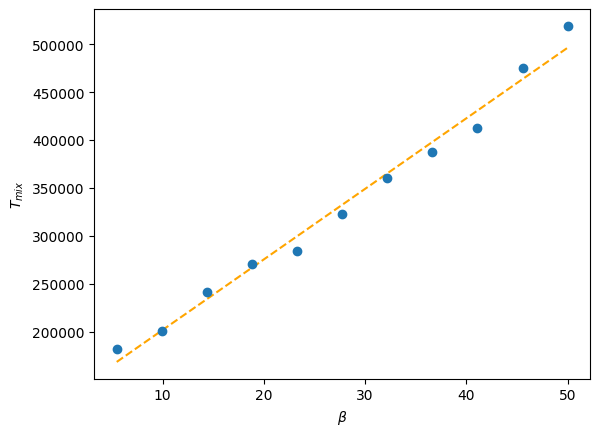

In [28]:
# linear fit
def linear(x,a,b):
    return a*x + b

p, pcov = curve_fit(linear, betas[1:], T_mix[1:])

print('N = 3    a = {:.3f} +/- {:.3f}     b = {:.3f} +/- {:.3f}'.format(p[0], pcov[0][0], p[1], pcov[1][1]))
y = [linear(beta, p[0], p[1]) for beta in betas[1:]]

plt.plot(betas[1:], y, label = 'fit', color = 'orange', linestyle = '--', zorder = 1)
plt.scatter(betas[1:], T_mix[1:], label = 'data', zorder = 2)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$T_{mix}$')



# Trace plots

We use arviz to analyze trace plots, mcse etc...

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean links,1.457,0.018,1.424,1.49,0.002,0.001,87.0,272.0,1.06


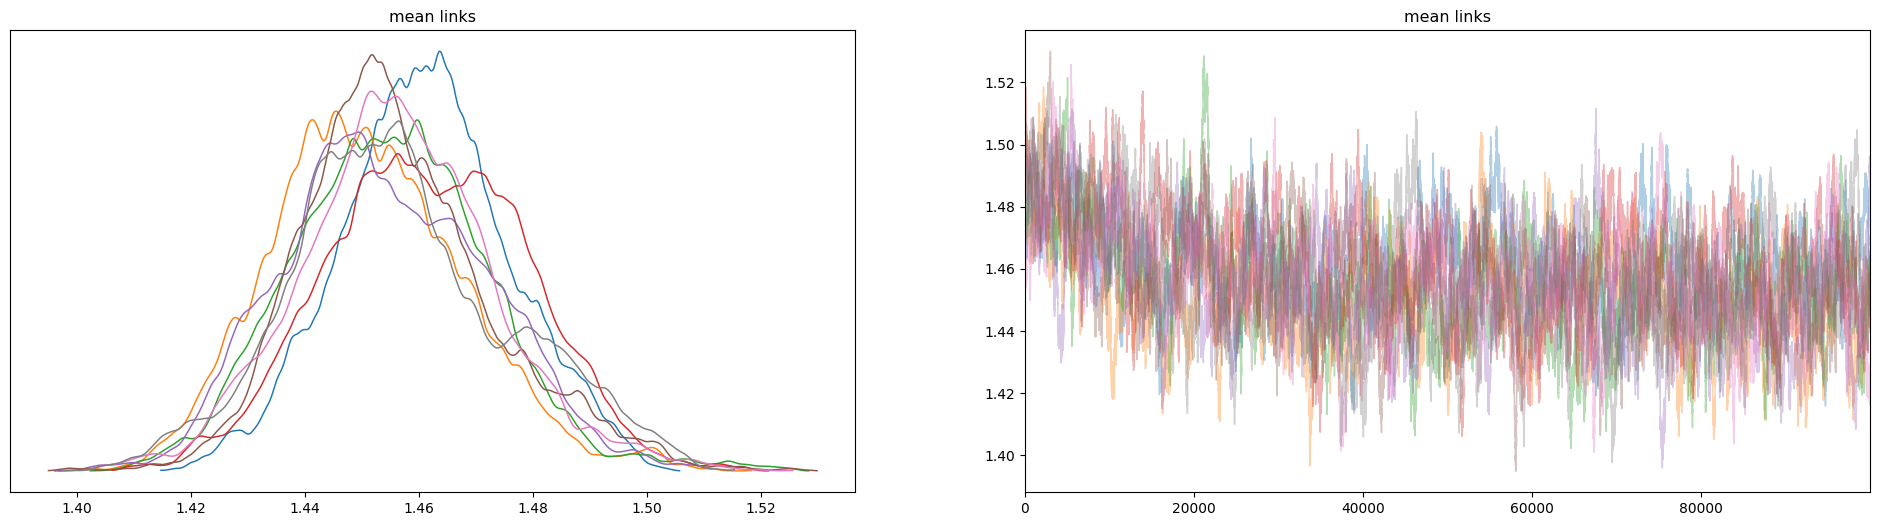

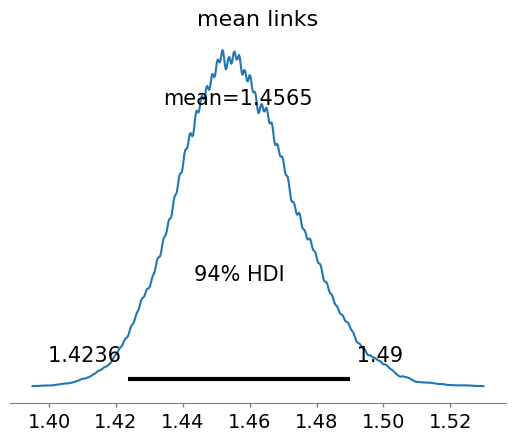

In [17]:
with open('data/run_3_64_2024-03-18_10_58_55.json', 'r') as file:
    data = json.load(file)
    

idata = az.convert_to_inference_data(data)
az.plot_trace(idata, compact=False, figsize=(24,6))
az.plot_posterior(idata, round_to=5)
#az.plot_autocorr(idata, max_lag=5000)
#az.plot_rank(idata)
az.summary(idata)

# mean links vs beta

$$
\langle m \rangle = C  \beta \qquad C = 0.99966 \pm 10^{-5}, \quad \beta \geq 5
$$

indipendent of num_colors (checked for 2 and 3)

In [29]:
betas = [5, 10, 15, 20, 25, 30]

STEPS = 100_000
SAMPLE_RATE = 10_000

mean_links = []
mean_links_2 = []

for beta in tqdm(betas):
    # 3 colors
    m = StateSpace(num_colors = 3, grid_size = 32, beta = beta , init = 0, bc = 0, algo='metropolis')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)  #0.1875
    # reach eq.
    m.step(500_000, progress_bar = False)
    # sample
    m.step(STEPS, sample_rate=SAMPLE_RATE, observables=[m.mean_links], progress_bar = False)
    
    mean_links.append( np.mean(np.sum(m.data['mean_links'], axis=1)) )
    
    # 2 colors
    m = StateSpace(num_colors = 2, grid_size = 32, beta = beta , init = 0, bc = 0, algo='metropolis')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)  #0.1875
    # reach eq.
    m.step(500_000, progress_bar = False)
    # sample
    m.step(STEPS, sample_rate=SAMPLE_RATE, observables=[m.mean_links], progress_bar = False)
    
    mean_links_2.append( np.mean(np.sum(m.data['mean_links'], axis=1)) )

  0%|          | 0/6 [00:00<?, ?it/s]

N = 3    a = 0.998678 +/- 0.000001     b = -0.511 +/- 0.000
N = 2    a = 1.001337 +/- 0.000003     b = -0.279 +/- 0.001


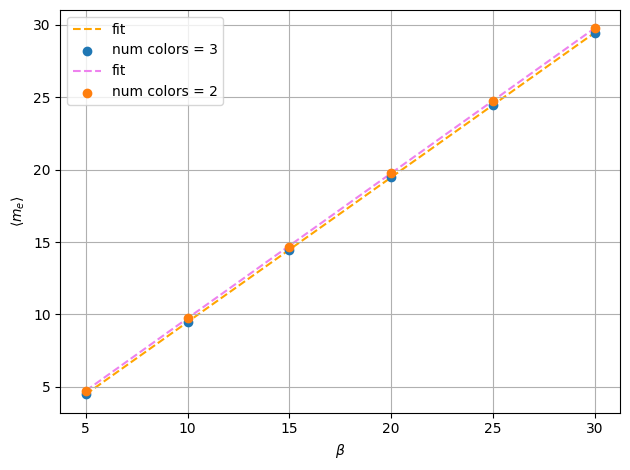

In [30]:
# acceptance_prob_optimized
def linear(x,a,b):
    return a*x + b

p, pcov = curve_fit(linear, betas, mean_links)

print('N = 3    a = {:.6f} +/- {:.6f}     b = {:.3f} +/- {:.3f}'.format(p[0], pcov[0][0], p[1], pcov[1][1]))
y = [linear(beta, p[0], p[1]) for beta in betas]

plt.plot(betas,y, label = 'fit', color = 'orange', linestyle = '--', zorder = 1)
plt.scatter(betas, mean_links, label = 'num colors = 3', zorder = 2)

p, pcov = curve_fit(linear, betas, mean_links_2)
print('N = 2    a = {:.6f} +/- {:.6f}     b = {:.3f} +/- {:.3f}'.format(p[0], pcov[0][0], p[1], pcov[1][1]))
y = [linear(beta, p[0], p[1]) for beta in betas]

plt.plot(betas,y, label = 'fit', color = 'violet', linestyle = '--', zorder = 1)
plt.scatter(betas, mean_links_2, label = 'num colors = 2', zorder = 2)

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle m_e \rangle$')


# Adjust layout
plt.tight_layout()

plt.legend()
plt.grid()

plt.savefig(MEDIA_PATH + 'mean_links_vs_beta_2_3.pdf')
plt.show()

# Loops

  0%|          | 0/1000000 [00:00<?, ?it/s]

number of loops: 506
mean length: 10.34387351778656


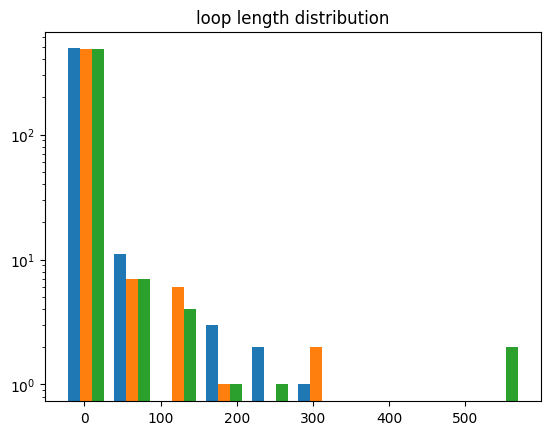

In [31]:
# choose a color
color = 0

m = StateSpace(3, 64, 2.5)
m.step(1_000_000)
loops, lengths = m.loop_builder()


plt.hist(lengths, log=True, align='left') 
plt.title('loop length distribution')

print('number of loops: {}'.format(len(loops[color])))
print('mean length: {}'.format(np.mean(lengths[color])))


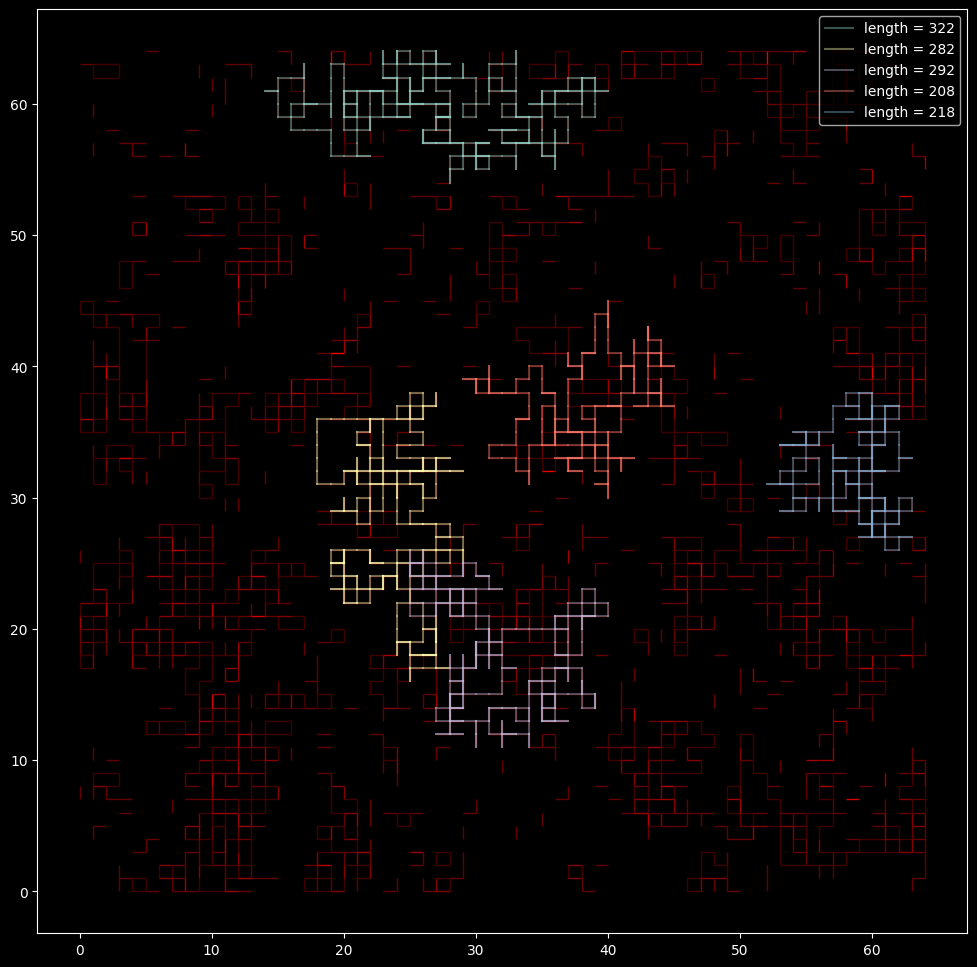

In [55]:
from itertools import cycle

plt.style.use("dark_background")

colors = cycle([plt.cm.Set2(i) for i in range(8)])

# find top 10 longest loops
# print top 10
loops_sorted = np.sort(lengths[color])[-5:]

top =  []

for l in loops[color]:
    if len(l) in loops_sorted:
        top.append(l)

#plot them
m.plot_loop(color, top, alpha=0.4) 

[0.061520825372564, 0.055789071455865494, 0.05387848681696599, 0.04165074512800917, 0.039740160489109666, 0.038975926633549866, 0.019870080244554833, 0.019105846388995033, 0.01757737867787543, 0.01757737867787543, 0.01757737867787543, 0.016048910966755828, 0.015666794038975928, 0.014520443255636225, 0.014520443255636225, 0.012991975544516622, 0.012991975544516622, 0.010317157050057318, 0.009552923194497517, 0.009552923194497517, 0.009170806266717615, 0.008788689338937715, 0.008406572411157814, 0.008406572411157814, 0.008406572411157814, 0.008406572411157814, 0.008024455483377914, 0.0072602216278181125, 0.006878104700038212, 0.006878104700038212, 0.006495987772258311, 0.006495987772258311, 0.00611387084447841, 0.005349636988918609, 0.004967520061138708, 0.0045854031333588076, 0.0045854031333588076, 0.0045854031333588076, 0.0045854031333588076, 0.004203286205578907, 0.004203286205578907, 0.004203286205578907, 0.004203286205578907, 0.004203286205578907, 0.004203286205578907, 0.00382116927

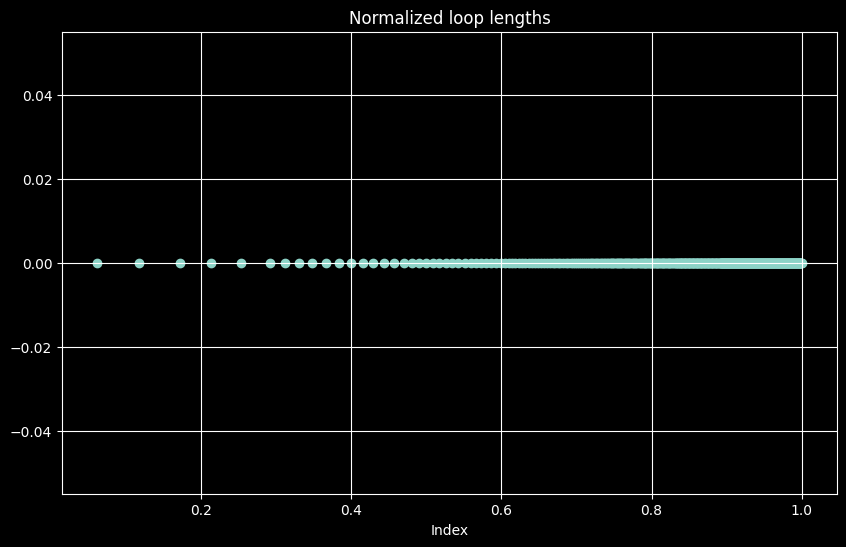

In [56]:
# normalize lenghts
tot_length = np.sum(lengths[0])

lengths_norm_sorted = sorted([l/tot_length for l in lengths[0]], reverse=True)
print(lengths_norm_sorted)
y = np.zeros_like(lengths_norm_sorted)


# Calculating the cumulative sums
cumulative_sums = [sum(lengths_norm_sorted[:i+1]) for i in range(len(lengths_norm_sorted))]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(cumulative_sums, y) 
plt.title('Normalized loop lengths')
plt.xlabel('Index')
plt.grid(True)
plt.show()

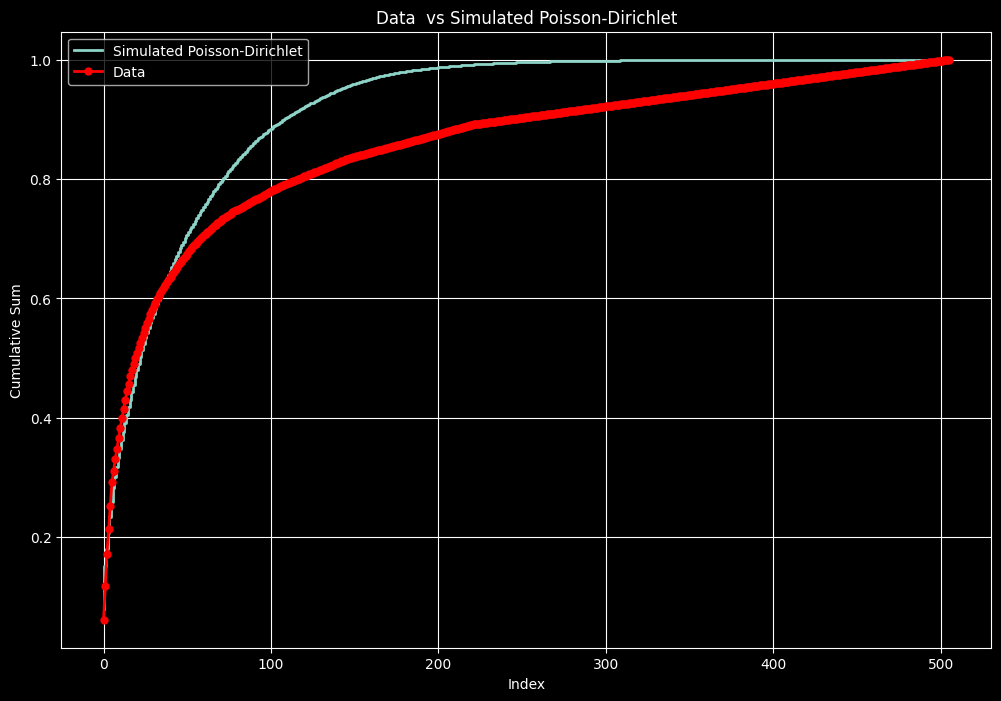

In [57]:
def simulate_stick_breaking(alpha, num_samples):
    betas = np.random.beta(1, alpha, num_samples)
    remaining_stick_lengths = np.cumprod(1 - betas)
    stick_pieces = betas * np.concatenate(([1], remaining_stick_lengths[:-1]))
    return stick_pieces

# Simulate data from the stick-breaking process
alpha = 50  # Example concentration parameter
simulated_data = simulate_stick_breaking(alpha, len(cumulative_sums))
simulated_data_sorted = np.sort(simulated_data)[::-1]
cumulative_sums_simulated = np.cumsum(simulated_data_sorted)

# Your normalized lengths data (placeholder, replace with your actual data)
# This assumes lengths_norm_sorted and cumulative_sums are defined as in your code snippet
# lengths_norm_sorted = ...

# Plotting both datasets for comparison
plt.figure(figsize=(12, 8))
plt.step(range(len(cumulative_sums_simulated)), cumulative_sums_simulated, where='mid', label='Simulated Poisson-Dirichlet', linewidth=2)
plt.plot(range(len(cumulative_sums)), cumulative_sums, 'ro-', linewidth=2, markersize=5, label='Data')  # Adjusted for visualization
plt.title('Data  vs Simulated Poisson-Dirichlet')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.legend()
plt.show()

# Correlations

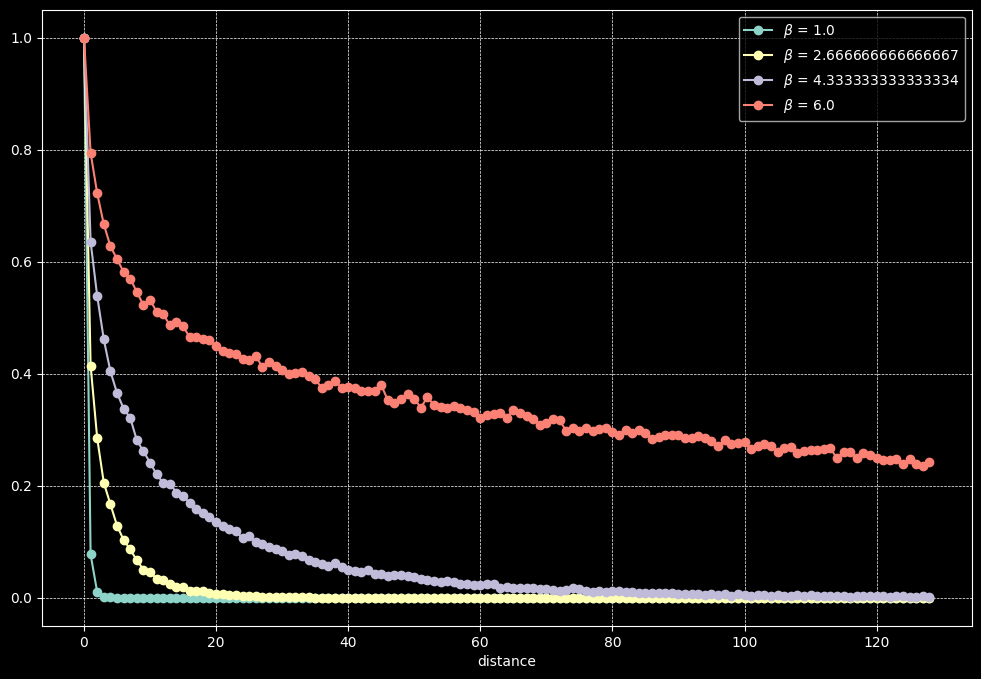

In [63]:
with open('data/corr_3_256_2024-03-17_12_29_40.json', 'r') as file:
    data = json.load(file)
    
data = np.array(data['data'])

data_mean = np.mean(data, axis=0)

# plot relevant observables normalized to last value
fig, ax = plt.subplots(figsize = (12,8))
betas = np.linspace(1,6,4)
for i in range(len(data_mean)):
    x = np.arange(0, 129, 1)
    ax.plot(x, data_mean[i], label=r'$\beta$ = {}'.format(betas[i]), marker='o')
    ax.legend()
    ax.set_xlabel('distance')
    ax.grid(linewidth=0.5, linestyle = '--')
        #ax.set_xticks(np.arange(0, STEPS, STEPS // 10))
        
#fig.suptitle(r'Normalized observables       grid size = {}'.format(m.grid_size))
plt.savefig(MEDIA_PATH + 'corr_256.pdf')
plt.show()



               beta = 1.0
--- exp ---
a = 2.553 +/- 0.000        res = 1.961e-05
--- pow ---
a = 3.751 +/- 0.000        res = 7.155e-05

               beta = 2.666666666666667
--- exp ---
a = 0.586 +/- 0.000        res = 5.392e-02
--- pow ---
a = 1.255 +/- 0.000        res = 1.096e-02

               beta = 4.333333333333334
--- exp ---
a = 0.151 +/- 0.000        res = 3.432e-01
--- pow ---
a = 0.715 +/- 0.000        res = 1.620e-01

               beta = 6.0
--- exp ---
a = 0.019 +/- 0.000        res = 2.968e+00
--- pow ---
a = 0.273 +/- 0.000        res = 2.318e-02


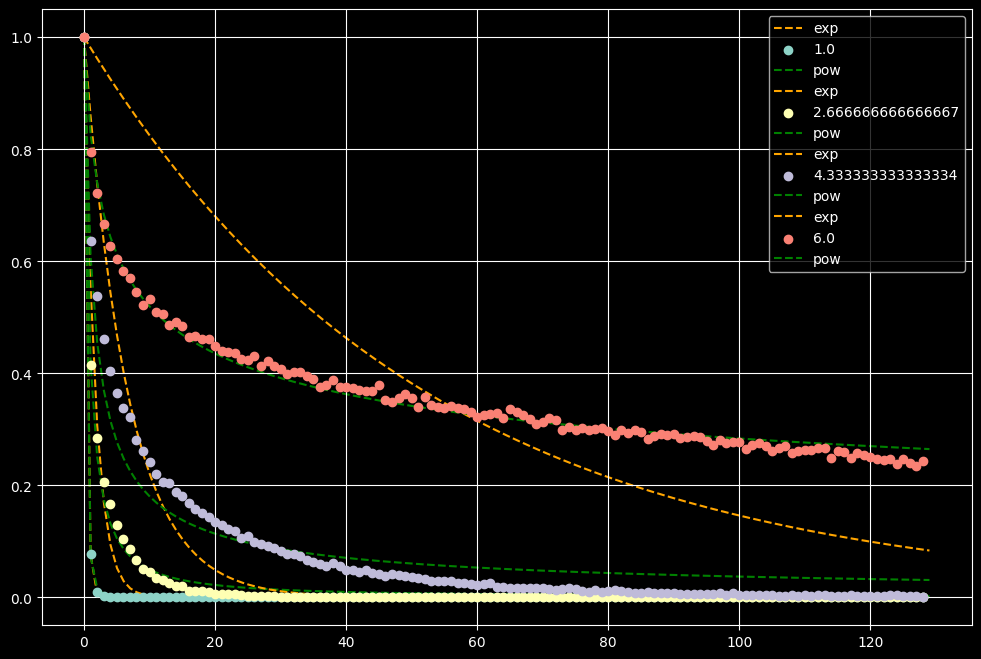

In [71]:
# fit to check if decay is exp or pow

plt.figure(figsize=(12,8))


def fit_plot(data, betas):
    x = np.arange(0, len(data[0]))
    for i in range(len(data)):
        print(f'\n               beta = {betas[i]}')
        # fit best exp
        y = data[i]
        p, pcov = curve_fit(lambda x, a: np.exp(-a*x), x, y, p0 = (-1))
        x_fit = np.linspace(0, len(data[0]), len(data[0]))
        y_fit_exp = np.exp(-x_fit * p[0])
        res = np.sum( (y-y_fit_exp)**2)
        print('--- exp ---')
        print('a = {:.3f} +/- {:.3f}        res = {:.3e}'.format(p[0], pcov[0][0], res))
       
        plt.plot(x_fit, y_fit_exp, label = 'exp', color = 'orange', linestyle = '--', zorder = 1)
        plt.scatter(x, y, label = f'{betas[i]}', zorder = 2)

        # fit best pow
        p, pcov = curve_fit(lambda x, a: 1/(x+1)**a, x, y, p0 = (1), maxfev=10_000)
        y_fit_pow = 1/(x_fit+1)**p[0]
        res = np.sum( (y-y_fit_pow)**2)
        print('--- pow ---')
        print('a = {:.3f} +/- {:.3f}        res = {:.3e}'.format(p[0], pcov[0][0], res))
        plt.plot(x_fit, y_fit_pow, label = 'pow', color = 'green', linestyle = '--', zorder = 1)
                    
    plt.legend()
    plt.grid()
    plt.show()
    
fit_plot(data_mean, np.linspace(1, 6, 4))